### NOTE: Neither the lines of code nor text have been proofread

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
from IPython.display import Video, HTML

### Camera Calibration

**Introduction**

Quite simply, this is the process of 'undistorting' a photograph taken by a camera, but what do we mean by this?

Let us look at a picture of a makeshift chess board I took with my webcam (at close range)

(<matplotlib.image.AxesImage at 0x1c814bfddc8>, ([], []), ([], []))

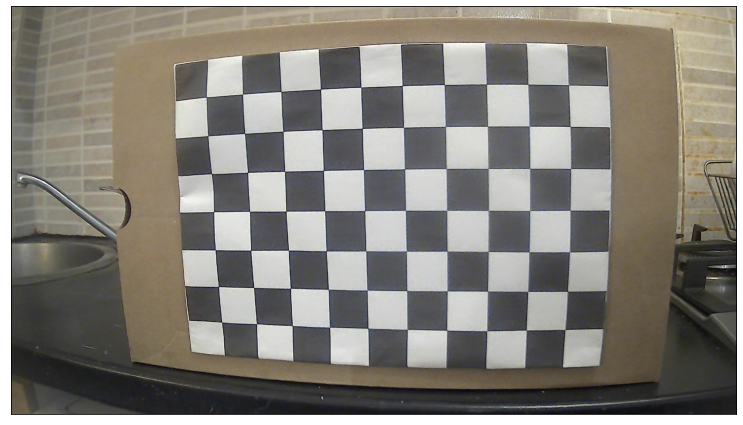

In [2]:
picture = cv.imread('bank_images/ForCamCalib/z2_Folder/WIN_20240314_16_32_20_Pro.jpg')

# View on Matplotlib
rgb_picture = cv.cvtColor(picture, cv.COLOR_BGR2RGB)
plt.figure(figsize=(13,11))
plt.imshow(rgb_picture),plt.xticks([]),plt.yticks([])

If you look closely at the picture, you will notice that the chess board appears to be bulging outwards (as does the kitchen bench (which was in need of a good wash post-cooking!)). As a matter of fact, the chess board (and kitchen bench) are perfectly straight, but they appear to be bulging out because the webcam I used is a *pinhole* camera. In fact most cameras in use today are pinhole cameras and the bulging out caused by the camera is called ***radial distortion***.

This distortion becomes larger the further away from the centre a point is. An idea of the mathematics of this can be read at:
<br>
https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

Although distortion of images are often undesirable, they can also be highly useful in the creative arts (sometimes the effect is used to make something look bigger than it actually is!). That said, correcting the distortion is very useful, expecially for stereo applications.

In addition to radial distortion, there is also ***tangential distortion***, which is where the camera is not aligned perfectly parallel with the imaging plane (as is the case with the picture above). Again, an idea of the mathematics of this can be found in the same site as before.

Two further factors are ***intrinsic*** and ***extrinsic factors***. The former relate to the camera and are specific to the camera, and include *focal length* and *optical centre*; these two can be combined into a *camera matrix* (see the same site as before). Extrinsic factors relate to *rotation* and *translation* vectors which translate the 3D coordinates of a point in the real world.

One way of obtaining the 3D coordinates of a point in the real world is by using a chess board (with its regular alternation of black and white squares). We place the chess board on the table and take pictures of it with the camera. The chess board is not moved while the camera is placed at different angles for each picture taken of the board. That way, *z = 0*, but *x* and *y* change. With this approach, we can label each internal corner of the chess board, using a system such as (0, 0, 0), (1, 0, 0), (2, 0, 0) ..., (6, 5, 0) ... (remember *z* stays fixed at 0). These 3D coordinates are converted to 2D coordinates in the picture. 3D coordinates are called ***object points*** and 2D coordinates are called ***image points***

Our 3D and 2D coordinates are used to solve for five *distortion coefficients*; at least 10 pictures (that is, 10 &times; 3D coordinates and 10 &times; 2D coordinates); are required for a good estimate of the distortion coefficients.

With appropriate input data, we can find the chess square corners by using <code>cv.findChessboardCorners()</code> and <code>cv.cornerSubPix()</code> (the latter improves the accuracy of the former). We can then draw markers on the corners and join them using <code>cv.drawChessboardCorners()</code>

We will now demonstrate this using

(<matplotlib.image.AxesImage at 0x1c814c02688>, ([], []), ([], []))

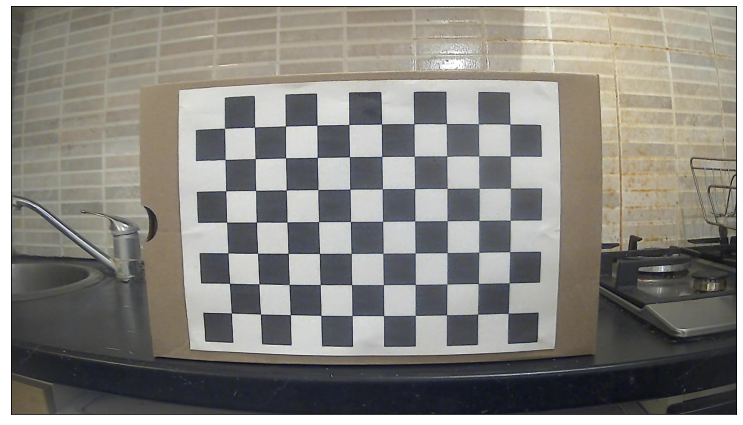

In [3]:
picture = cv.imread('bank_images/ForCamCalib/img_1.jpg')

# View on Matplotlib
rgb_picture = cv.cvtColor(picture, cv.COLOR_BGR2RGB)
plt.figure(figsize=(13,11))
plt.imshow(rgb_picture),plt.xticks([]),plt.yticks([])

It appears the chess board needs to have a white border for <code>cv.findChessboardCorners()</code> to work
<br>
https://answers.opencv.org/question/196196/finding-chessboard-corners-doesnt-work-on-thresholded-images/

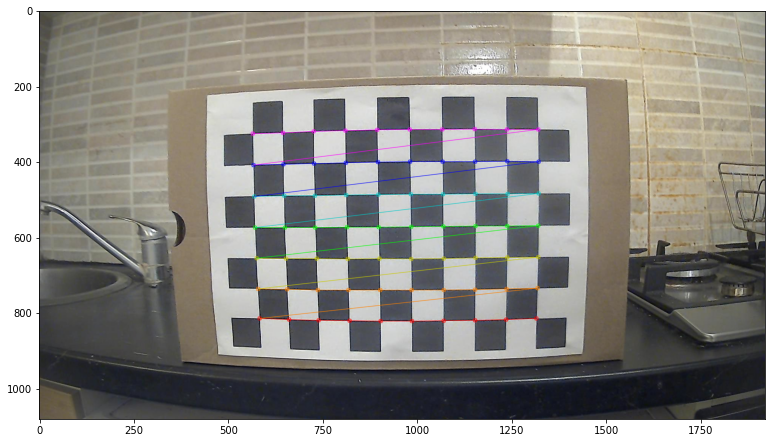

In [24]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)  # np.zeros((H*W,3), np.float32) Notice the H and W
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2) # np.mgrid[0:W,0:H]  See where H and W are now

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('bank_images/ForCamCalib/*.jpg')

img = cv.imread(images[0]) # The chess board should have a white border 
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, (10,7), None)  # Note: (10,7) is (W,H)

# If found, add object points, image points (after refining them)
if ret == True:
    objpoints.append(objp)
    corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners2)

    # Draw and display the corners
    chess = cv.drawChessboardCorners(img, (10,7), corners2, ret)  # Here too, (10,7) is (W,H)
    rgb_chess = cv.cvtColor(chess, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(13,11))
    plt.imshow(rgb_chess)

else:
    print('No corners detected!')

Let us now process all 10 pictures I've taken

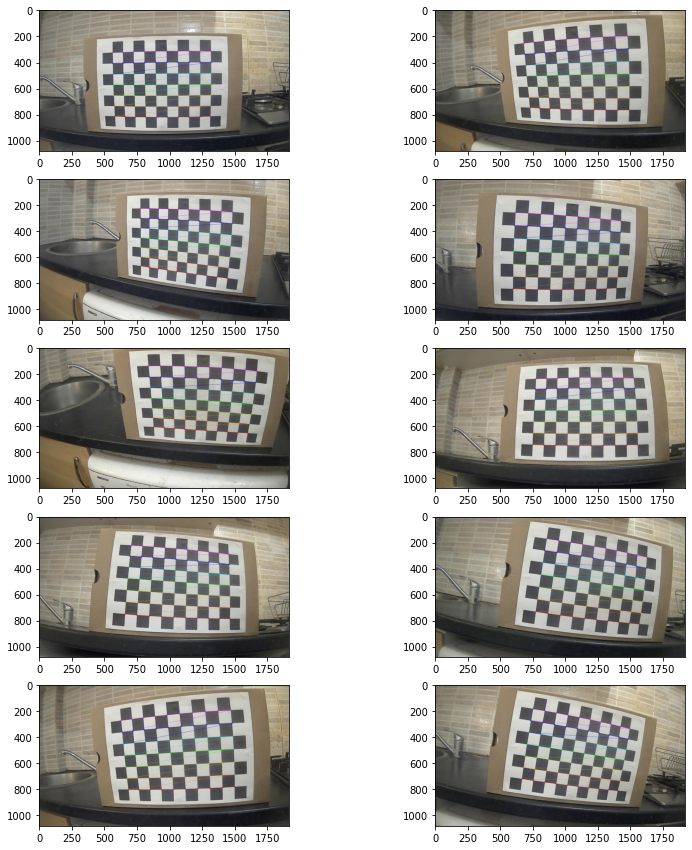

In [25]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('bank_images/ForCamCalib/*.jpg')

plt.figure(figsize=(13,15))

for fname in images:

    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (10,7), flags=cv.CALIB_USE_INTRINSIC_GUESS)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        chess = cv.drawChessboardCorners(img, (10,7), corners2, ret)
        rgb_chess = cv.cvtColor(chess, cv.COLOR_BGR2RGB)
        plt.subplot(5,2,images.index(fname)+1)
        plt.imshow(rgb_chess)

    else:
        print('No corners detected!')

Let's see of we can generate an undistorted image of the chess board

(<AxesSubplot:title={'center':'Distortion removed'}>,
 Text(0.5, 1.0, 'Distortion removed'))

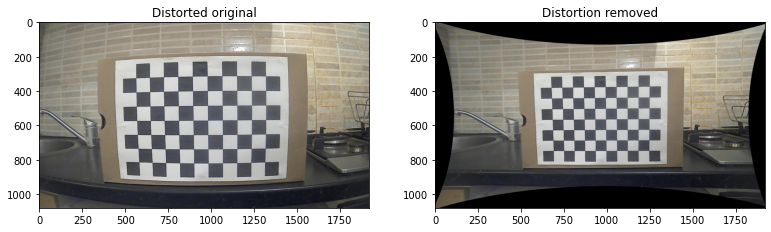

In [6]:
img = cv.imread(images[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
# x, y, w, h = roi
# dst = dst[y:y+h, x:x+w]

rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
rgb_dst = cv.cvtColor(dst, cv.COLOR_BGR2RGB)
plt.figure(figsize=(13,11))
plt.subplot(1,2,1),plt.imshow(rgb_img),plt.title('Distorted original')
plt.subplot(1,2,2),plt.imshow(rgb_dst),plt.title('Distortion removed')

Excellent, notice how so much smaller the chess board looks now and how straight things appear. Also notice how the margins of the picture cave inwards.

Let's save this

In [125]:
img = cv.imread(images[0])
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

h,  w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv.undistort(img, mtx, dist, None, newcameramtx)
cv.imwrite('bank_images/ForCamCalib/Distortion_removed/img_1_undistorted.jpg', dst)

True

Great!

But just one more thing, how accurate are our found parameters. This accuracy is known as the *re-projection error* and the closer it is to 0, the more accurate our found parameters are.

Let's find out

In [127]:
mean_error = 0

for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
print( "total error: {}".format(mean_error/len(objpoints)) )

total error: 0.0836144907187307


Not bad.

An alternative to a chess board is a circular grid. In place of <code>cv.findChessboardCorners()</code>, you would use <code>cv.findCirclesGrid()</code>

Let's save our parameters for our webcam so that we can use them for other files

In [7]:
np.savez_compressed('6D_CamCalib.npz', mtx=mtx, dist=dist, rvecs=rvecs, tvecs=tvecs)

For more details on saving data using Numpy, see https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html

The cells below are just a few reminders for me!

In [74]:
gray.shape[::1]

(1080, 1920)

In [75]:
gray.shape[::-1]

(1920, 1080)

In [78]:
img.shape

(1080, 1920, 3)

In [82]:
img.shape[:2]

(1080, 1920)

In [91]:
ls = [1,2,3]
ls.index(1)

0

### Pose Estimation

**Introduction**

This is a computer's attempt at identifying the position and orientation of a person or object. This is something humans (and indeed all animals) do instinctively, but for computers, it is incredibly complicated (to design), involving lots (and lots) of *partial differential equations*. Pose estimation is extremely important to robotics and self-driving vehicles. Also see:
<br>
https://paperswithcode.com/task/pose-estimation
<br>
https://viso.ai/deep-learning/pose-estimation-ultimate-overview/
<br>
https://www.sciencedirect.com/science/article/pii/S0957417423003391
<br>
https://en.wikipedia.org/wiki/Six_degrees_of_freedom

**Brief comparision with humans**

For a human, the image of the person/object (seen by the human) is captured by the eye, which sends the information to the *visual cortex* in the brain. On its way from the eyes to the visual cortex, the information is broken down into fractions and each fraction is processed by a specific layer of the visual cortex. That means that each layer of the visual cortex only gets 'part of the picture'. This bears similarities to a group of deep learning neural networks, used by computers, called *convulated neural networks*. In a computer (equipped with such a network), the image of the person/object is captured by its camera(s), which send(s) the information to the computer's convulated neural network (more on that later).

**Challenges for computer vision**

Humans and animals not only get information about the position and orientation of an object through their eyes, but also through their ears and muscles and all of these play important roles in pose estimation. Computers do not have such an abundance of sources for sensory information and given the complexity in developing algorithms for this, it is unsurprising that applications which enable computers perform pose estimation tend to be selective as to what they work (well) with. In other words, an application that works well for a certain class of objects (in a certain scenario) cannot be expected to work well in others (https://en.wikipedia.org/wiki/3D_pose_estimation).

**Caibration of the camera**

Earlier, we calibrated our webcam and used the obtained parameters of the calibration to obtain an undistorted picture of a chess board. We will use those parameters we obtained to do pose estimations of some of the initial distorted pictures I took with the webcam.

**Constructing a 3D axis**

To do this, we will use many of the lines of code that were used for producing the undistorted picture (from the original distorted picture). In addition, a function that enables us draw the lines of the axes (via <code>cv.line</code>) will also be required.

In [30]:
def draw(img, corners, imgpts):
    
    """For drawing 3D axes with cv.line()"""
    
    # Extract coordinates for cv.line (from corners and imgpts)
    corner_list = list(corners[0].ravel())
    imgpts_0_list = list(imgpts[0].ravel())
    imgpts_1_list = list(imgpts[1].ravel())
    imgpts_2_list = list(imgpts[2].ravel())
    
    # Convert floats to integers (as cv.line works best with integers)
    corner_tuple = tuple(list(map(int, corner_list)))
    imgpts_0_tuple = tuple(list(map(int, imgpts_0_list)))
    imgpts_1_tuple = tuple(list(map(int, imgpts_1_list)))
    imgpts_2_tuple = tuple(list(map(int, imgpts_2_list)))
    
    # Plug integers into cv.line function
    img = cv.line(img, corner_tuple, imgpts_0_tuple, (255,0,0), 5)
    img = cv.line(img, corner_tuple, imgpts_1_tuple, (0,255,0), 5)
    img = cv.line(img, corner_tuple, imgpts_2_tuple, (0,0,255), 5)
    
    return img

We can now plug this into our chess board

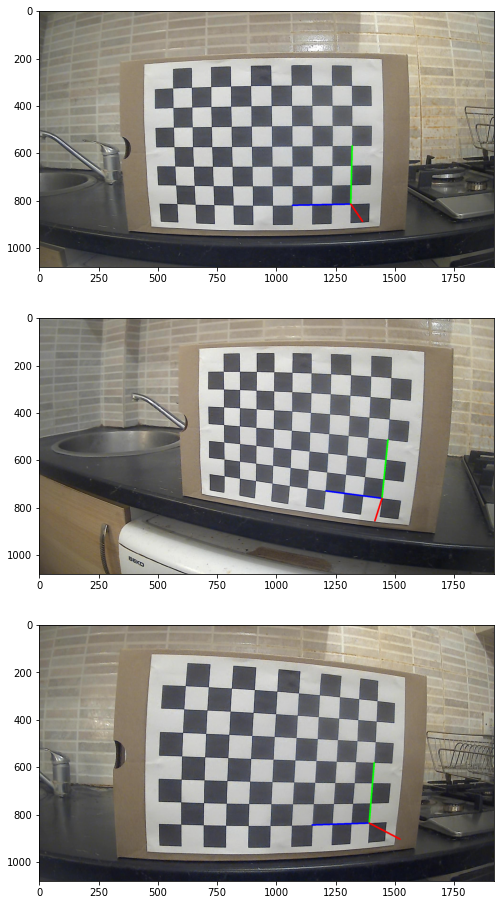

In [37]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

axis = np.float32([[3,0,0], [0,3,0], [0,0,-3]]).reshape(-1,3)

plt.figure(figsize=(13,16))
selected_for_plt = [0,2,3]

# Load saved camera parameters
with np.load('6D_CamCalib.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]
    
    for fname in images:

        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (10,7), flags=cv.CALIB_USE_INTRINSIC_GUESS)

        if ret == True:
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

            # Find the rotation and translation vectors.
            ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)

            # Draw axes
            img = draw(img,corners2,imgpts)
            rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            # Selected for display on Matplotlib
            if images.index(fname) in selected_for_plt:
                plt.subplot(3, 1, selected_for_plt.index(images.index(fname))+1)
                plt.imshow(rgb_img)
        else:
            print('Problem(s) with data!')      

Great, let us extend this a construct a cube

In [46]:
def cube(img, corners, imgpts):
    
    """For drawing cube with OpenCV using calibrated camera data"""
    
    # Extract origins for cube (from corners and imgpts)
    corner_list = list(corners[0].ravel())
    corner_tuple = tuple(list(map(int, corner_list)))

    # Reshape imgpts
    imgpts = np.int32(imgpts).reshape(-1,2)
    
    # Draw ground floor in green
    img = cv.drawContours(img, [imgpts[:4]],-1,(0,255,0),-3)
    
    # Draw pillars in blue color
    for i,j in zip(range(4),range(4,8)):
        img = cv.line(img, tuple(list(map(int, list(imgpts[i])))),
                      tuple(list(map(int, list(imgpts[j])))), (255), 3)
        # Draw top layer in red color
        img = cv.drawContours(img, [imgpts[4:]],-1,(0,0,255),3)
    
    return img

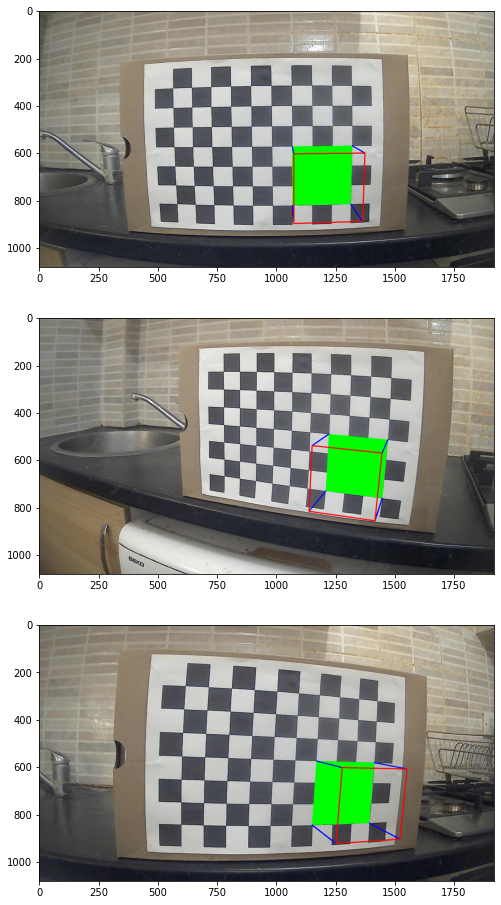

In [47]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((7*10,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

axis = np.float32([[0,0,0], [0,3,0], [3,3,0], [3,0,0], [0,0,-3], [0,3,-3], [3,3,-3], [3,0,-3] ])

plt.figure(figsize=(13,16))
selected_for_plt = [0,2,3]

# Load saved camera parameters
with np.load('6D_CamCalib.npz') as X:
    mtx, dist, _, _ = [X[i] for i in ('mtx','dist','rvecs','tvecs')]
    
    for fname in images:

        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (10,7), flags=cv.CALIB_USE_INTRINSIC_GUESS)

        if ret == True:
            corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)

            # Find the rotation and translation vectors.
            ret,rvecs, tvecs = cv.solvePnP(objp, corners2, mtx, dist)

            # project 3D points to image plane
            imgpts, jac = cv.projectPoints(axis, rvecs, tvecs, mtx, dist)

            # Draw axes
            img = cube(img,corners2,imgpts)
            rgb_img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

            # Selected for display on Matplotlib
            if images.index(fname) in selected_for_plt:
                plt.subplot(3, 1, selected_for_plt.index(images.index(fname))+1)
                plt.imshow(rgb_img)
        else:
            print('Problem(s) with data!')      

Also see:
<br>
https://docs.opencv.org/3.4/d7/d53/tutorial_py_pose.html

***Uncalibrated camera***

It is possible to determine pose estimation using an uncalibrated camera; see:
<br>
https://en.wikipedia.org/wiki/3D_pose_estimation
<br>
https://github.com/opencv/opencv/wiki/Posit

**Human pose estimation using deep learning**

So far, we have not looked at how deep learning (or indeed any form of machine learning) may be employed in pose estimation; we shall now look at the use of deep learning in human pose estimation.

***Deep learning (Machine learning)***

This has already been introduced extensively in the NN series of screenshots in *Extensive Intro to Neural Nets_selectedss*, which in turn was part of the extensive *Python – Data Science and Machine Learning* course I undertook a while ago. But basically, the computer is learning by using artifical neural networks.

In machine learning, a neuron is essentially a mathematical function *f(X)* with one or more inputs <em>x<sub>pre</sub></em> and one or more outputs <em>x<sub>post</sub></em> (whicn in turn act as inputs for other neurons). If the output is the final outcome, then <em>x<sub>post</sub></em> becomes <em>y</em>.

Each <em>x<sub>pre</sub></em> input is *weighted* and *biased* differently to the others as shown:

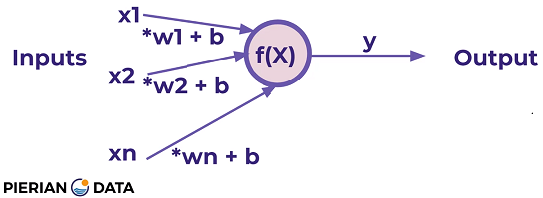

A neural network becomes 'deep' if it has two or more middle layers; these middle layers are called *hidden layers* and exactly which input they receive from the preceding layer is not always known. There are different groups or types of neural networks, but the three most popular are:

<ul>
    <li>Multilayer Perceptrons (MLPs)</li>
    <li>Convulated Neural Network (CNN)</li>
    <li>Recurrent Neural Network (RNN)</li>
</ul>

*Multilayer Perceptrons (MLPs)*

Here, all neurons in one layer are connected to all neurons in the previous  and proceeding layers; it is a *feed-forward* neural network.

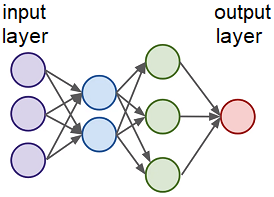

This sort of network is prone to overfitting of data although this can be reduced by switching off (or 'dropping') a proportion of neurons in each layer and making use of 'early stopping'. 'Dropping' can slow down the learning rate and 'early stopping' can limit the time the network spends learning the data. I built several of these, and the NN series of screenshots illustrates this extensively.

*Convulated Neural Network (CNN)*

This is also a feed-forward neural network, but unlike MLPs, no one neuron in any layer is connected to all neurons in the preceding or proceeding layer. This means that each neuron only gets part of the information from the preceding layer. However, parts of information in a subpopulation of neurons in one layer will tend to converge to fewer neurons in the proceeding layer as shown:

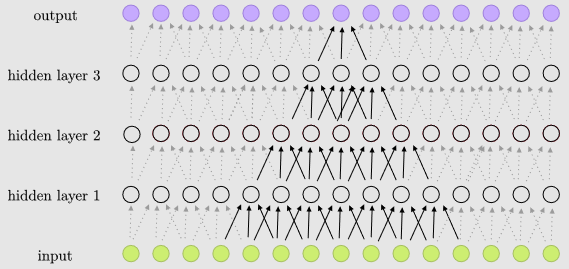

As alluded to earlier, there are similarities here with the way the visual cortex processes visual information, so it should come as no surprise to know that CNNs are used extensively in computer vision. We will return to CNNs and use it for pose estimation later on, but for more info:
<br>
https://en.wikipedia.org/wiki/Convolutional_neural_network

*Recurrent Neural Network (RNN)*

Unlike feed-forward networks (MLPs and CNNs) which only allow information to flow in one direction, RNNs are *bi-directional* In the hidden layers, the output from one layer is sent to the proceeding layer, but it also turns back on itself and inputs into the neuron it came out from in the first place (or other neurons in the same layer).

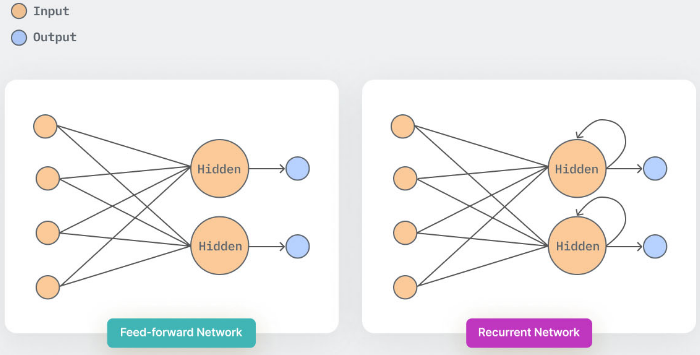

This leads to an updating of the information the neuron received from the preceding layer, *not triggered by the sender in the preceding layer*. The process repeats itself until an equilibrium is reached.

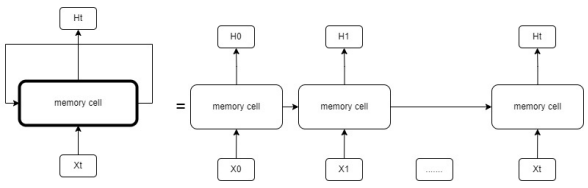

This type of network is ideal for sequential data, enabling the prediction of the next data point **before** it is even entered. Hence, RNNs are used for natural language processing (NLP) and predictive text; for more on this, see:
<br>
https://www.v7labs.com/blog/recurrent-neural-networks-guide
<br>
https://www.diva-portal.org/smash/get/diva2:1632760/FULLTEXT02

***Deep learning example for human pose estimation***

Various libraries are required to build neural networks; many are included in deep learning libraries such as TensorFlow. Examples of CNN libraries can be found at 
<br>
https://viso.ai/deep-learning/deep-neural-network-three-popular-types/
<br>

An example of how a CNN might be built can be found at:
<br>
https://www.kaggle.com/code/nicuwi/mobilenet-v1


Of course, buidling a neural network is one thing, being able to use it properly in your project or application is quite another. In this example, I will use the free version of OpenPose (from GitHub) to perform a pose estimation of myself in front of my webcam. OpenPose is a popular pose estimation application that utilises TensorFlow, as well as MobileNetV1 (a CNN library), which comes on the back of TensorFlow
<br>
https://paperswithcode.com/method/mobilenetv1
<br>
https://viso.ai/deep-learning/openpose/
<br>
For examples of other deep learning pose estimation applications, see
<br>
https://viso.ai/deep-learning/pose-estimation-ultimate-overview/

*OpenPose with OpenCV in deep learning pose estimation example*

I did not do this on Jupyter Notebook but used Command Prompt. I used the video https://www.youtube.com/watch?v=nUjGLjOmF7o&t=14s for guidance, which I thought was still very useful even several years after it was made although as of January 2024:

```bash
$ git clone https://www.github.com/ildoonet/tf-openpose
```
is now:

```bash
$ git clone https://github.com/ZheC/tf-pose-estimation.git
```
which means:

```bash
$ cd tf-openpose
```
has become:

```bash
$ cd tf-pose-estimation
```
In addition, I had to change quite a few lines of code in the estimator.py and network_base.py files since the original lines of code in those files were originally written for TensorFlow 1 (and I'm using TensorFlow 2). I named my conda environment *tf_vision* and after I had correctly amended and set up everything, I eventually ran

```bash
$ python src/run_webcam.py --model=mobilenet_thin_432x368 --camera=0
```

The results are not bad.

I've decided to save footage of this. To that end, I am copying run_webcam.py and adding extra lines of code to the copy that will eventually enable me run

```bash
$ python src/run_webcam2.py --model=mobilenet_thin_432x368 --camera=0
```

Let's play the video here

In [5]:
HTML("""
<video width="320" height="240" controls>
  <source src="tf-pose-estimation/PoseEst1.mp4" type="video/mp4">
</video>
""")

Although I have managed to save something to video, I'm unable to get the frame rates for live capture and write to match. The end result being that the live capture is too slow and the writing of processed frames to disk produces a video with me moving too fast at 30 frames per second. I can eleviate this by slowing the frame rate of the written video; 4 frames per second appears to do it

I will try to play it on OpenCV

In [9]:
cap = cv.VideoCapture('tf-pose-estimation/PoseEst1.mp4')

while cap.isOpened():
    ret, frame = cap.read()
     # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    else:
        cv.imshow('frame', frame)
        if cv.waitKey(1) == ord('q'):
            break

Can't receive frame (stream end?). Exiting ...


In [10]:
cap.release()

In [11]:
cv.destroyAllWindows()

Jupyter Notebook appears to be struggling with the exceptionally slow frame rate and appears to be playing it at a much higher frame rate. This means the video produced is literally over before I even get the chance to click the icon to view it here on Jupyter Notebook.

I think I will record myself using my computer ap and then import that here and use a slimmed down version of OpenPose to perform human pose estimation. (The slimmed down version of OpenPose can be obtained here https://automaticaddison.com/human-pose-estimation-using-deep-learning-in-opencv/)

I have found that I get poorer performance if I try executing the code on Jupyter Notebook and so I will execute this on a terminal

```bash
$ python openpose2.py
```

Done; now unfortunately, Jupyter Notebook is unable to play the video, not even with the HTML video tag, but my computer can play it and I like the result!

In [3]:
import numpy as np

In [4]:
y = np.array([1,2,3,4])
y[:2]

array([1, 2])